In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv
from pylab import *
import scipy
from scipy.signal import find_peaks
from sklearn.metrics import r2_score
from scipy.fftpack import fft,fftfreq

In [2]:
def retrieve_param(folder_name: str):
    file_param = "Figures/" + folder_name + "/param.txt"
    # file_param = "/Volumes/Elements/Documents/2. Cambridge/3. MPhil/4. Python code/cell-migration/results/Figures/" + folder_name + "/param.txt"
    file = open(file_param, 'r')

    i = 0
    # Saving all the parameters in the good variable
    for line in file:
        if i == 2:
            h = float(line[3:])
        if i == 3:
            dim_x = float(line[7:])
        if i == 4:
            dim_y = float(line[7:])
        if i == 5:
            nx = int(line[4:])
        if i == 6:
            ny = int(line[4:])
        if i == 7:
            n = int(line[3:])
        if i == 8:
            dt = float(line[4:])
        if i == 9:
            theta = float(line[7:])
        if i == 10:
            Cahn = float(line[6:])
        if i == 11:
            Pe = float(line[4:])
        if i == 12:
            Ca = float(line[4:])
        if i == 13:
            starting_point = float(line[16:])
        if i == 14:
            h_0 = float(line[5:])
        if i == 15:
            k_wave = float(line[8:])
        if i == 16:
            sigma = float(line[7:])
        if i == 17:
            q = float(line[3:])
        if i==18:
            alpha = float(line[7:]) 
        i += 1
    file.close()
    return h, dim_x, dim_y, nx, ny, n, dt, theta, Cahn, Pe, Ca, starting_point, h_0, k_wave, sigma, q, alpha

In [3]:
def interface_to_array(file_name, n,ny, dim_y):
    interface_coord = np.zeros((n,ny+1,2))
    
    N = ny+1

    with open(file_name, 'r') as file:
        reader = csv.reader(file, delimiter=' ')
        for row in reader:
            time = int(float(row[0])*10000)/10000
            i = int(round(time/dt))
            arr_interface = np.asarray(row[1:], dtype=float)
            interface_coord[i] =  arr_interface.reshape(N,2)
            
            #print(time)
            #print(i)
            
            # fig = plt.figure(figsize=(20,10))
            # plt.plot(interface_coord[i,:,1],interface_coord[i,:,0])
            # plt.title('Time = ' + str(time))
            # plt.show()
            # plt.close(fig)
            
            
        
        # if i < 125:
        #     line = np.asarray(row, dtype=float)
        #     n = int(line.shape[0] / 2)
        #     intf = line.reshape(n, 2)
        #     beg = int(n / 3)
        #     end = int(2 * n / 3)
        #     intf = intf[intf[:, 1] < 16]
        #     intf_mid = intf[intf[:, 1] > 3]
        #     approx_mid = np.sum(intf_mid[:, 0]) / intf_mid.shape[0]
        #     mid[i] = approx_mid
        #     i += 1
        # else:
        #     break
        
        return interface_coord
    
def width_to_array(file_name_width, n, ny, dim_y):
    mean_width = np.zeros((n,2))
    
    N = ny+1

    with open(file_name_width, 'r') as file:
        reader = csv.reader(file, delimiter=' ')
        for row in reader:
            time = int(float(row[0])*10000)/10000
            i = int(round(time/dt))
            mean_width[i] = np.asarray(row[1:], dtype = float)
    
    return np.asarray(mean_width)

def extract_spectrum(n,ny,dim_y, interface_coord,h):
    
    freq_max = np.zeros((n,3))
    amplitude = np.zeros(n)
    mid = np.zeros(n)
    
    amplitude_f2 = np.zeros(n)
    
    
    for i in range(n):
        signal = interface_coord[i,:,0]
        N = signal.size
        # Y_k = np.fft.fft(signal)[0:int(N/2)]/N # FFT function from numpy
        # Y_k[1:] = 2*Y_k[1:] # need to take the single-sided spectrum only
        # Pxx = np.abs(Y_k) # be sure to get rid of imaginary part
        
        Te=h
            
        # Frequencies
        freq = fftfreq(N,Te)
        freq = freq[range(int(N/2))]
        # Normalized FFT + single-sided pisitive spectrum
        S = 2*fft(signal)/N
        S = S[range(int(N/2))]
        a_0 = S[0].real/2
        S = abs(S)
        
        # Remove null frequency
        S=S[1:]
        freq=freq[1:]
        
        peaks, _ = find_peaks(S, height = 0.02)
        # peaks, _ = find_peaks(S)
        
        # peaks=np.array([0])
                
        # print(S[peaks])
        # print(freq[peaks])
    
        # # plotting
        # fig,ax = plt.subplots()
        # plt.plot(freq,S)
        # ax.set_xscale('log')
        # plt.plot(freq[peaks],S[peaks] , "x")
        # plt.ylabel('Amplitude')
        # plt.xlabel(r'Frequency (q/2$\pi$) (log)')
        # plt.title('Time = ' + str(i*dt))
        # #plt.axis([0,15,0,0.02])
        # plt.show()
        # plt.close()
        
        mid[i] = a_0
        
        if peaks.size==1:
            freq_max[i,0] = freq[peaks]
            amplitude[i] = S[peaks]
        if peaks.size==2:
            freq_max[i,0:2] = freq[peaks]
            amplitude[i] = S[peaks[0]]
            amplitude_f2[i] = S[peaks[1]]
        if peaks.size==3:
            freq_max[i,:] = freq[peaks]
            amplitude[i] = S[peaks[0]]
            amplitude_f2[i] = S[peaks[1]]
        if peaks.size>3:
            freq_max[i,:] = freq[peaks[0:3]]
            amplitude[i] = S[peaks[0]]
            amplitude_f2[i] = S[peaks[1]]
                        
                
        
        
        # f = dim_y*np.arange(0,int((N/2)))/N; # frequency vector
        # 
        # a_0 = real(Y_k[0])
        # mid[i] = a_0
        # 
        # Pxx = Pxx[1:]
        # f = f[1:]
        # 
        # peaks, _ = find_peaks(Pxx, height = 0.003, distance = 100)
        # 
        # if peaks.shape[0]==2:
        #     freq_max[i,0:2] = f[peaks]
        #     amplitude_f2[i] = Pxx[peaks[1]]
        # if peaks.shape[0]==1:
        #     freq_max[i,0] = f[peaks]
        #     amplitude_f2[i] = 0
        # if peaks.shape[0]>=3:
        #     freq_max[i,:] = f[peaks[0:3]]
        #     amplitude_f2[i] = Pxx[peaks[1]]
        # if peaks.shape[0]==0:
        #     freq_max[i,0] = freq_max[i-1,0]
        #     amplitude[i] = amplitude[i-1]
        #     amplitude_f2[i] = 0
        # if peaks.shape[0]!=0:
        #     amplitude[i] = Pxx[peaks[0]]
        
        
    
    return freq_max, amplitude, mid, amplitude_f2


In [17]:
folder_name = '1-7-2020#6'
file_name = "Figures/" + folder_name + "/interface.csv"
file_name_width = "Figures/" + folder_name + "/interface_width.csv"
file_save= "Figures/" + folder_name +"/Analysis"
# file_name = "/Volumes/Elements/Documents/2. Cambridge/3. MPhil/4. Python code/cell-migration/results/Figures/" + folder_name + "/interface.csv"
# file_save= "/Volumes/Elements/Documents/2. Cambridge/3. MPhil/4. Python code/cell-migration/results/Figures/" + folder_name
# file_name_width = "/Volumes/Elements/Documents/2. Cambridge/3. MPhil/4. Python code/cell-migration/results/Figures/" + folder_name + "/interface_width.csv"

Theta= 5.0  , alpha= 1.2 , Pe= 0.2 ,  Cahn= 0.2 , h= 0.03125


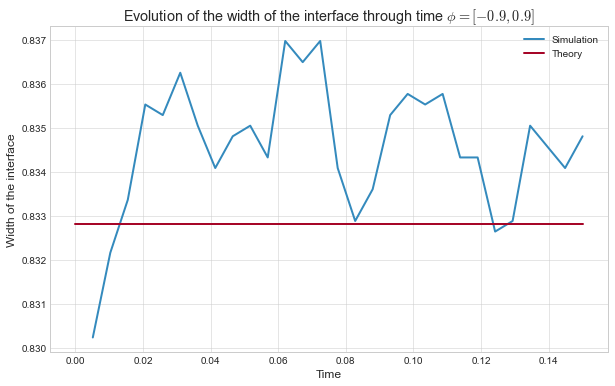

0.0


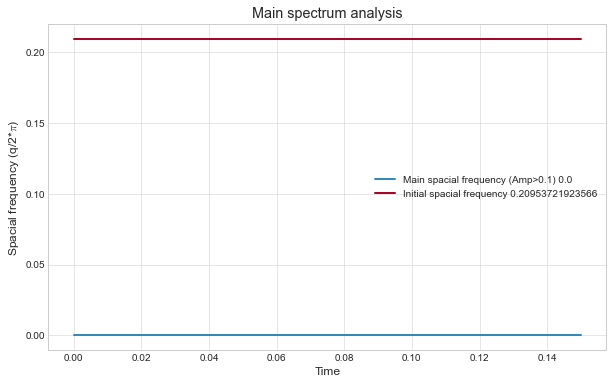

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


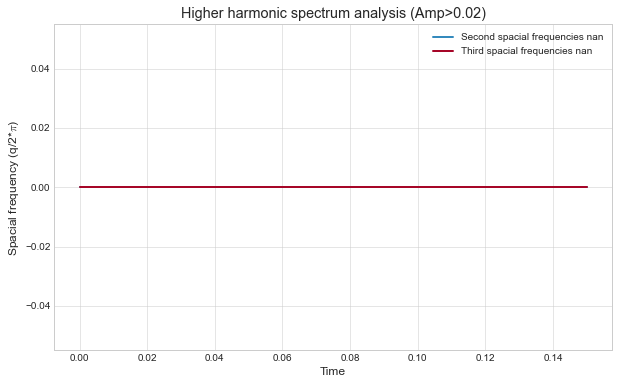

0.9574287259522519


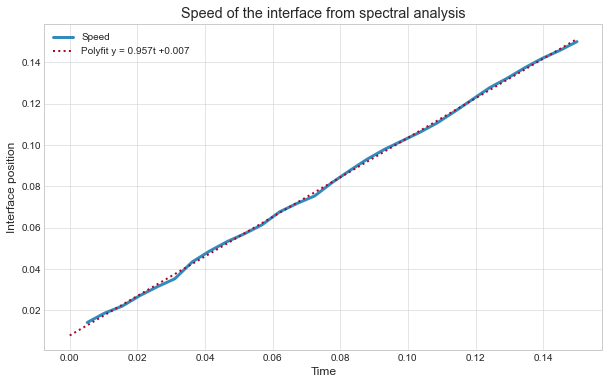

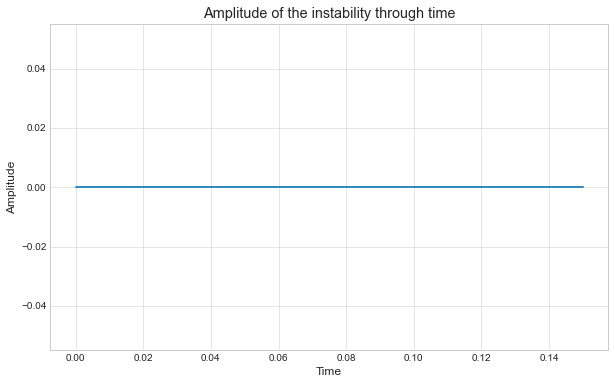

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:137: RuntimeWarning: divide by zero encountered in log


Expected sigma = -0.2564078747657058
[nan nan]


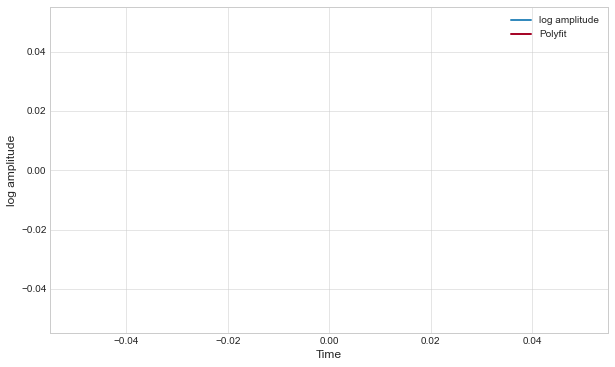

In [18]:
h, dim_x, dim_y, nx, ny, n, dt, theta, Cahn, Pe, Ca, starting_point, h_0, k_wave, sigma, q, alpha = retrieve_param(folder_name)

print('Theta= ' + str(theta), ' , alpha= ' + str(alpha) + ' , Pe= ' + str(Pe) + ' ,  Cahn= ' + str(Cahn) + ' , h= ' + str(h))

T = np.linspace(0,n*dt,n)
interface_coord = interface_to_array(file_name, n,ny, dim_y)

freq_max, amplitude, mid, amplitude_f2 = extract_spectrum(n,ny,dim_y, interface_coord,h)


# Width

width = width_to_array(file_name_width, n, ny, dim_y)

T_w = T[T>0.2]
width_t = width[T>0.2, 0]
width_t = width_t[T_w<1.2]
# T_w = T_w[T_w<1.2]
# z_w = np.polyfit(T_w, width_t, 1)
# p_w = np.poly1d(z_w)

# print(z_w)
# print('Sigma corr')
# print(sigma*np.sqrt(3*Ca*np.arctan(0.9)/z_w[1]))

fig = plt.figure(figsize=(10,6))
plt.style.use('bmh')
plt.style.use('seaborn-whitegrid')
plt.plot(T[1:],width[1:,0])
plt.plot(T, np.ones(n)*2*np.sqrt(2)*Cahn*np.arctanh(0.9))
# plt.plot(T_w, p_w(T_w))
plt.xlabel('Time')
plt.ylabel(r'Width of the interface')
plt.legend(['Simulation', 'Theory'], loc=0)
plt.title(r'Evolution of the width of the interface through time $\phi = [-0.9, 0.9]$')
plt.show()
plt.close(fig)

# fig = plt.figure(figsize=(10,6))
# plt.style.use('bmh')
# plt.style.use('seaborn-whitegrid')
# plt.plot(T[1:],width[1:,1])
# plt.xlabel('Time')
# plt.ylabel(r'STD of the width of the interface')
# plt.title(r'STD of the width of the interface through time $\phi = [-0.9, 0.9]$')
# plt.show()
# plt.close(fig)



# Initial and main frequency

print(max(freq_max[:,0]))

fig = plt.figure(figsize=(10,6))
plt.style.use('bmh')
plt.style.use('seaborn-whitegrid')
plt.plot(T,freq_max[:,0])
plt.plot(T, np.ones(n)*k_wave/(2*np.pi))
plt.legend(['Main spacial frequency (Amp>0.1) ' + str(max(freq_max[:,0])), 'Initial spacial frequency '+ str(k_wave/(2*np.pi))], loc=0)
plt.title('Main spectrum analysis')
plt.xlabel('Time')
plt.ylabel(r'Spacial frequency (q/2*$\pi$)')
#plt.axis([0,1.5,0,max(1.2*k_wave/(2*np.pi), 1.2*freq_max[:,0])
plt.savefig(fname = file_save + "/Main_spectral_analysis.png", dpi=300)
plt.show()
plt.close(fig)

# Secondary frequency

f2 = freq_max[:,1]
f2 = f2[f2>0]

f3 = freq_max[:,2]
f3 = f3[f3>0]

fig = plt.figure(figsize=(10,6))
plt.plot(T,freq_max[:,1])
plt.plot(T,freq_max[:,2])
plt.legend(['Second spacial frequencies ' + str(np.mean(f2)), 'Third spacial frequencies ' + str(np.mean(f3))], loc=0)
plt.title('Higher harmonic spectrum analysis (Amp>0.02)')
plt.xlabel('Time')
plt.ylabel(r'Spacial frequency (q/2*$\pi$)')
plt.savefig(fname = file_save + "/Higher_spectral_analysis.png", dpi=300)
plt.show()
plt.close(fig)

#Speed

z = np.polyfit(T[1:], mid[1:], 1)
p = np.poly1d(z)
print(z[0])

fig = plt.figure(figsize=(10,6))
plt.plot(T[1:],mid[1:], lw=3)
plt.plot(T, p(T), ls='dotted')
plt.legend(['Speed', 'Polyfit y = ' + str(int(z[0]*1000)/1000) + 't +' + str(int(z[1]*1000)/1000) ])
plt.title('Speed of the interface from spectral analysis')
plt.xlabel('Time')
plt.ylabel(r'Interface position')
plt.savefig(fname = file_save + "/Speed_analysis.png", dpi=300)
plt.show()
plt.close(fig)

# Amplitude through time
fig = plt.figure(figsize=(10,6))
plt.plot(T,amplitude)
plt.title('Amplitude of the instability through time')
plt.ylabel('Amplitude')
plt.xlabel('Time')
plt.savefig(fname = file_save + "/Amplitude.png", dpi=300)
plt.show()
plt.close(fig)

# fig = plt.figure(figsize=(10,6))
# plt.plot(T,amplitude_f2)
# plt.legend(['Amplitude of the second harmonic'], loc=0)
# plt.title('Amplitude 2nd harmonic through time')
# plt.xlabel('Time')
# plt.ylabel(r'Spacial frequency (q/2*$\pi$)')
# plt.savefig(fname = file_save + "/Amplitude_2nd_harmonic.png", dpi=300)
# plt.show()
# plt.close(fig)
# 
# fig = plt.figure(figsize=(10,6))
# plt.plot(T,amplitude/amplitude_f2)
# plt.legend(['Ratio'], loc=0)
# plt.title('Ratio of amplitude 1st harmonic/2nd harmonic')
# plt.xlabel('Time')
# plt.ylabel(r'Spacial frequency (q/2*$\pi$)')
# plt.savefig(fname = file_save + "/Amplitude_ratio.png", dpi=300)
# plt.show()
# plt.close(fig)

#Amplitude through time log
T = np.linspace(0,n*dt,n)
ln_a = np.log(amplitude)
ln_a = ln_a[T<0.08]
T_bis = T[T<0.08]
#ln_a = ln_a[T_bis>0]
#T_bis = T_bis[T_bis>0]


#z_ln = np.polyfit(T_bis[T_bis<1.2], ln_a[T_bis<1.2], 1)  # TODO Do this with sklearn to have R^2 score
#z_ln = np.polyfit(T_bis, ln_a, 1)
z_ln = np.polyfit(T_bis, ln_a, 1)
p_ln = np.poly1d(z_ln)

#r2 = r2_score(ln_a, p_ln(T_bis))

# print('Expected sigma = ' + str(sigma))
print('Expected sigma = ' + str(-(k_wave**3-1)/theta))
print(z_ln)
#print('R2= ' + str(r2))

fig = plt.figure(figsize=(10,6))
plt.plot(T_bis,ln_a)
plt.plot(T_bis, p_ln(T_bis), '-')
plt.xlabel('Time')
plt.ylabel('log amplitude')
#plt.title('Amplitude of the instability through time (log scale) with linear fit \n Polyfit y= ' + str(int(z_ln[0]*100000)/100000) + 't +' + str(int(z_ln[1]*1000)/1000) + ' \n $R^2$ = ' + str(r2))
plt.legend(['log amplitude', 'Polyfit'])
plt.savefig(fname = file_save + "/Growth_rate_analysis.png", dpi=300)
plt.show()
plt.close(fig)

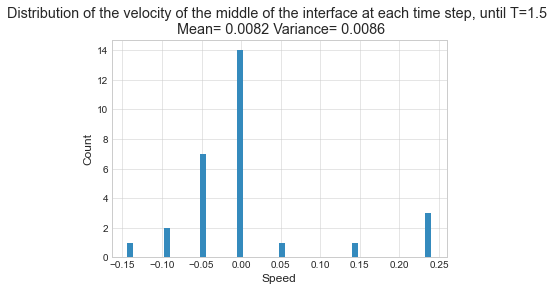

ValueError: x and y must have same first dimension, but have shapes (124,) and (29,)

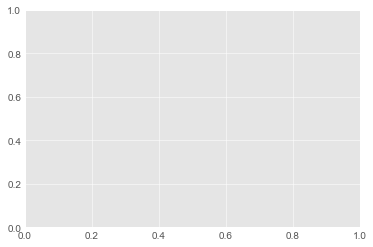

In [9]:
speed = (mid[1:] - mid[:-1]) / dt
mean = int(np.mean(speed) * 10000) / 10000
var = int(np.var(speed) * 10000) / 10000

plt.hist(speed, bins=50)
plt.title('Distribution of the velocity of the middle of the interface at each time step, until T=1.5 \n Mean= ' + str(mean) + ' Variance= ' + str(var))
plt.xlabel('Speed')
plt.ylabel('Count')
plt.style.use('ggplot')
#plt.savefig('Distrib speed for test ' + folder_name)
plt.show()
 
T = np.linspace(0,1.5,124)

plt.plot(T,speed)
plt.xlabel('Time')
plt.ylabel('Speed')
plt.title('Speed of the interface depending on the time')
#plt.savefig('Time-speed for test ' + folder_name)
plt.show()

T2 = np.linspace(0,1.5,125)
z= np.polyfit(T2, mid, 1)
print(z)

plt.plot(T2,mid)
plt.xlabel('Time')
plt.ylabel('Middle of the interface')
plt.title('Middle of the interface depending on the time')
plt.text(0.2, -2.2, 'Linear fit = '+ str(int(z[0]*1000)/1000)+' t ' + str(int(z[1]*1000)/1000))
plt.savefig('Time-position for test ' + folder_name)
plt.show()